In [1]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'
sqlpassword = 'postgres'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, password = sqlpassword)
cur = con.cursor()

In [4]:
query = \
"""
select * from all_data_mental
"""

cur.execute('SET search_path to ' + schema_name)
data = pd.read_sql_query(query,con)
data.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,icd9_code,age,gender,marital_status,insurance,...,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max
0,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00,NaT,311,47.819229,F,MARRIED,Private,...,117.00,52.0,71.0,63.20,36.599998,38.200001,37.33,30.0,104.0,360.0
1,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,29620,64.928234,F,MARRIED,Private,...,141.54,65.0,91.0,74.31,36.444444,37.444445,36.94,0.0,90.0,160.0
2,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaT,30029,74.384386,M,MARRIED,Medicare,...,121.62,33.0,61.0,47.74,35.900002,37.700001,37.03,40.0,153.0,760.0
3,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaT,3051,69.699821,M,MARRIED,Medicare,...,110.11,42.0,101.0,68.77,36.099998,37.500000,36.86,7.0,99.0,450.0
4,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,NaT,30000,72.728435,M,MARRIED,Medicare,...,127.95,48.0,100.0,71.39,35.722222,38.166667,37.26,10.0,146.0,1000.0


In [5]:
np.sum(data.isnull())


subject_id            0
hadm_id               0
admittime             0
dischtime             0
deathtime         18428
icd9_code             0
age                   0
gender                0
marital_status     1308
insurance             0
urea_n_min            9
urea_n_max            9
urea_n_mean           9
platelets_min        23
platelets_max        23
platelets_mean       23
magnesium_max       176
albumin_min        6263
calcium_min         475
resprate_min          8
resprate_max          8
resprate_mean         8
glucose_min         161
glucose_max         161
glucose_mean        161
hr_min                1
hr_max                1
hr_mean               1
sysbp_min             4
sysbp_max             4
sysbp_mean            4
diasbp_min            4
diasbp_max            4
diasbp_mean           4
temp_min             43
temp_max             43
temp_mean            43
urine_min             5
urine_mean            5
urine_max             5
dtype: int64

In [6]:
# calculate time delta between subsequent readmissions of the same patient 
data['readmit_dt'] = np.zeros(data.shape[0])
data['next_readmit_dt'] = np.zeros(data.shape[0])

for idx in np.arange(1,data.shape[0]):
    if data.subject_id[idx] == data.subject_id[idx - 1]:     
        prev_disch = data.dischtime[idx-1]
        curr_adm = data.admittime[idx]
        dt = curr_adm - prev_disch
        dt_hrs_calc = np.round(dt.value/3600.0/1e9,2)

#         data.set_value(idx,'adm_num',data['adm_num'][idx-1] + 1) 
        data.set_value(idx,'readmit_dt',dt_hrs_calc)
        data.set_value(idx-1,'next_readmit_dt',dt_hrs_calc)

C:\Users\Haoyuan\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
C:\Users\Haoyuan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [7]:
data.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,icd9_code,age,gender,marital_status,insurance,...,diasbp_max,diasbp_mean,temp_min,temp_max,temp_mean,urine_min,urine_mean,urine_max,readmit_dt,next_readmit_dt
0,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00,NaT,311,47.819229,F,MARRIED,Private,...,71.0,63.20,36.599998,38.200001,37.33,30.0,104.0,360.0,0.0,0.0
1,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,29620,64.928234,F,MARRIED,Private,...,91.0,74.31,36.444444,37.444445,36.94,0.0,90.0,160.0,0.0,0.0
2,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaT,30029,74.384386,M,MARRIED,Medicare,...,61.0,47.74,35.900002,37.700001,37.03,40.0,153.0,760.0,0.0,0.0
3,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaT,3051,69.699821,M,MARRIED,Medicare,...,101.0,68.77,36.099998,37.500000,36.86,7.0,99.0,450.0,0.0,26349.5
4,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,NaT,30000,72.728435,M,MARRIED,Medicare,...,100.0,71.39,35.722222,38.166667,37.26,10.0,146.0,1000.0,26349.5,0.0


In [8]:
data = data.drop(['urine_min','urine_mean','urine_max'], axis = 1) #Too noisy
data = data[data.readmit_dt >= 0] #Ignore cases where readmit_dt < 0, which result from duplicate records. 
data = data.ix[(data.deathtime.isnull())] #Remove cases where the patient died during stay
data = data.drop(['deathtime'], axis = 1) # Important to drop before dropna otherwise most of the data is lost

C:\Users\Haoyuan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
data.shape

(8831, 39)

In [9]:
threshold = 30*24
data['future_readmit'] = None
data['future_readmit'] = ['No' if dt == 0.0 else 'Yes' if dt<=threshold else 'No' for dt in data.next_readmit_dt]

In [10]:
print ('Value counts:')
print (data.future_readmit.value_counts())
print ('\nValue proportions:')
print (data.future_readmit.value_counts()/data.shape[0])

Value counts:
No     7580
Yes    4412
Name: future_readmit, dtype: int64

Value proportions:
No     0.632088
Yes    0.367912
Name: future_readmit, dtype: float64


In [11]:
data.to_csv('mental_admits_clean.csv', index=False)

In [12]:
from sklearn.preprocessing import StandardScaler
visualize = False
mental_admits_clean = pd.read_csv('mental_admits_clean.csv')

In [16]:
# Define label dataframe 
will_readmit = (mental_admits_clean.future_readmit == 'Yes')
y_df = pd.DataFrame(will_readmit.map({True: 1, False: 0}))
y_df.columns = ['label']

# Define feature dataframe and split into numerical and categorical features
x_df = mental_admits_clean.drop(['subject_id','hadm_id','admittime','dischtime','readmit_dt','readmit_last_careunit', 'future_readmit', 'next_readmit_dt' ,'albumin_min'], axis = 1)
x_df_cat = x_df[['gender', 'marital_status', 'insurance']].copy()
x_df_num = x_df.drop(['gender', 'marital_status', 'insurance'], axis = 1)

KeyError: "labels ['readmit_last_careunit'] not contained in axis"

In [52]:
np.sum(x_df_num.isnull())
x_df_num.fillna(x_df_num.mean(), inplace = True)

In [54]:
# Scale numerical features
scaled_x_df_num = pd.DataFrame(StandardScaler().fit_transform(x_df_num), columns=x_df_num.keys())


# Find outliers based on 1.5*(Q3-Q1) outlier step
outliers  = []
# For each feature find the data points with extreme high or low values
for feature in scaled_x_df_num.keys():
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(scaled_x_df_num[feature],25)
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(scaled_x_df_num[feature],75)
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    outliers_per_feature = scaled_x_df_num[~((scaled_x_df_num[feature] >= Q1 - step) & (scaled_x_df_num[feature] <= Q3 + step))]
    outliers = outliers + list(outliers_per_feature.index)
outliers.sort()
outliers = list(set(outliers))

# Remove outliers
clean_scaled_x_df_num = scaled_x_df_num.drop(scaled_x_df_num.index[outliers]).reset_index(drop = True)
print('{} outliers removed'.format(len(outliers)))


3754 outliers removed


In [55]:
# Convert categorical features to "One Hot Encoding" vectors
clean_x_df_cat = x_df_cat.drop(x_df_cat.index[outliers]).reset_index(drop = True)
clean_x_df_cat_ohe = pd.get_dummies(clean_x_df_cat, drop_first=True)

# Recombine scaled numerical and encoded categorical features by concatination
x_df = pd.concat([clean_scaled_x_df_num, clean_x_df_cat_ohe], axis = 1)

# Drop outliers from label Dataframe as well
y_df = y_df.drop(y_df.index[outliers]).reset_index(drop = True)

In [56]:
print ('Value counts:')
print (y_df.label.value_counts())
print ('\nValue proportions:')
print (y_df.label.value_counts()/y_df.shape[0])

Value counts:
0    3588
1    1489
Name: label, dtype: int64

Value proportions:
0    0.706717
1    0.293283
Name: label, dtype: float64


In [58]:
# Save preprocessed Dataframes to csv
x_df.to_csv('x_df.csv')
y_df.to_csv('y_df.csv')

    100% |████████████████████████████████| 645kB 5.5MB/s ta 0:00:011
  Stored in directory: /Users/Haoyuan/Library/Caches/pip/wheels/8a/89/0c/4870bb69132698f40889fa956f92e630a36c1fd7173fcc759f
Successfully built xgboost


In [60]:
import os
# Requirement in order to import xgboost
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.1.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

#import all relevant libraries
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
from scipy import interp

%matplotlib inline

In [61]:
# Read preprocessed dataframes produced in notebook 2_preprocessing.ipynb
x_df = pd.read_csv('x_df.csv')
y_df = pd.read_csv('y_df.csv')

In [62]:
# Define the class weight scale (a hyperparameter) as the ration of negative labels to positive labels.
# This instructs the classifier to address the class imbalance.
class_weight_scale = 1.*y_df.label.value_counts()[0]/y_df.label.value_counts()[1]
class_weight_scale

2.409670920080591

In [63]:
# Setting minimal required initial hyperparameters

param={
    'objective':'binary:logistic',
    'nthread':4,
    'scale_pos_weight':class_weight_scale,
    'seed' : 1   
}
xgb1 = XGBClassifier()
xgb1.set_params(**param)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2.409670920080591,
       seed=1, silent=True, subsample=1)

class weight scale : 2.4097397145256085
class weight scale : 2.4097397145256085
class weight scale : 2.4097397145256085
class weight scale : 2.4105793450881614
class weight scale : 2.408557046979866


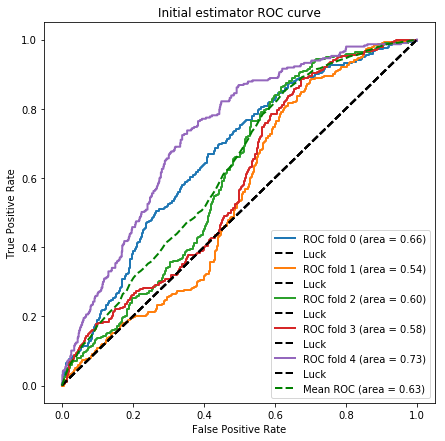

In [66]:
# Train initial classifier and analyze performace using K-fold cross-validation 
K = 5
eval_size = int(np.round(1./K))
skf = StratifiedKFold(n_splits=K)

fig = plt.figure(figsize=(7,7))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw = 2
i = 0
roc_aucs_xgb1 = []
for train_indices, test_indices in skf.split(x_df, y_df['label']):
    X_train, y_train = x_df.iloc[train_indices], y_df['label'].iloc[train_indices]
    X_valid, y_valid = x_df.iloc[test_indices], y_df['label'].iloc[test_indices]
    class_weight_scale = 1.*y_train.value_counts()[0]/y_train.value_counts()[1]
    print ('class weight scale : {}'.format(class_weight_scale))
    xgb1.set_params(**{'scale_pos_weight' : class_weight_scale})
    xgb1.fit(X_train,y_train)
    xgb1_pred_prob = xgb1.predict_proba(X_valid)
    fpr, tpr, thresholds = roc_curve(y_valid, xgb1_pred_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    roc_aucs_xgb1.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= K
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Initial estimator ROC curve')
plt.legend(loc="lower right")

fig.savefig('initial_ROC.png')

In [68]:
# Option to perform hyperparameter optimization. Otherwise loads pre-defined xgb_opt params
optimize = True
X_train = x_df
y_train = y_df['label']

if optimize:
   
    param_test0 = {
     'n_estimators':range(50,250,10)
    }
    print ('performing hyperparamter optimization step 0')
    gsearch0 = GridSearchCV(estimator = xgb1, param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch0.fit(X_train,y_train)
    print (gsearch0.best_params_, gsearch0.best_score_)

    param_test1 = {
     'max_depth':range(1,10),
     'min_child_weight':range(1,10)
    }
    print ('performing hyperparamter optimization step 1')
    gsearch1 = GridSearchCV(estimator = gsearch0.best_estimator_,
     param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch1.fit(X_train,y_train)
    print (gsearch1.best_params_, gsearch1.best_score_)

    max_d = gsearch1.best_params_['max_depth']
    min_c = gsearch1.best_params_['min_child_weight']
    
    param_test2 = {
     'gamma':[i/10. for i in range(0,5)]
    }
    print ('performing hyperparamter optimization step 2')
    gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_, param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch2.fit(X_train,y_train)
    print (gsearch2.best_params_, gsearch2.best_score_)

    param_test3 = {
        'subsample':[i/10.0 for i in range(1,10)],
        'colsample_bytree':[i/10.0 for i in range(1,10)]
    }
    print ('performing hyperparamter optimization step 3')
    gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_, 
     param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch3.fit(X_train,y_train)
    print (gsearch3.best_params_, gsearch3.best_score_)

    param_test4 = {
        'reg_alpha':[0, 1e-5, 1e-3, 0.1, 10]
    }
    print ('performing hyperparamter optimization step 4')
    gsearch4 = GridSearchCV(estimator = gsearch3.best_estimator_, 
     param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch4.fit(X_train,y_train)
    print (gsearch4.best_params_, gsearch4.best_score_)

    alpha = gsearch4.best_params_['reg_alpha']
    if alpha != 0:
        param_test4b = {
            'reg_alpha':[0.1*alpha, 0.25*alpha, 0.5*alpha, alpha, 2.5*alpha, 5*alpha, 10*alpha]
        }
        print ('performing hyperparamter optimization step 4b')
        gsearch4b = GridSearchCV(estimator = gsearch4.best_estimator_, 
         param_grid = param_test4b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
        gsearch4b.fit(X_train,y_train)
        print (gsearch4b.best_params_, gsearch4.best_score_)
        print ('\nParameter optimization finished!')
        xgb_opt = gsearch4b.best_estimator_
        xgb_opt
    else:
        xgb_opt = gsearch4.best_estimator_
        xgb_opt
else: 
    # Pre-optimized settings
    xgb_opt = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=70, nthread=4,
       objective='binary:logistic', reg_alpha=25.0, reg_lambda=1,
       scale_pos_weight=7.0909090909090908, seed=1, silent=True,
       subsample=0.6)
    
print (xgb_opt)

performing hyperparamter optimization step 0
{'n_estimators': 50} 0.6572846223987285
performing hyperparamter optimization step 1
{'max_depth': 1, 'min_child_weight': 1} 0.7382142750141921
performing hyperparamter optimization step 2
{'gamma': 0.0} 0.7382142750141921
performing hyperparamter optimization step 3
{'colsample_bytree': 0.9, 'subsample': 0.3} 0.7413979222145585
performing hyperparamter optimization step 4
{'reg_alpha': 0} 0.7413979222145585
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=2.408557046979866, seed=1, silent=True,
       subsample=0.3)


class weight scale : 2.4097397145256085
class weight scale : 2.4097397145256085
class weight scale : 2.4097397145256085
class weight scale : 2.4105793450881614
class weight scale : 2.408557046979866


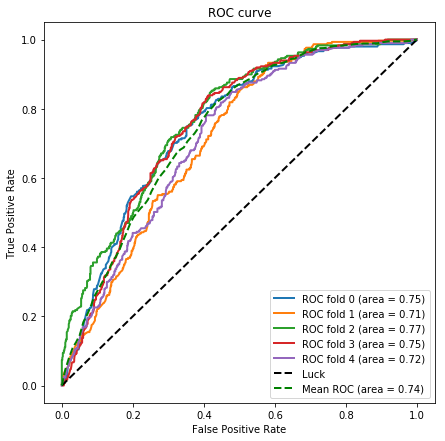

In [70]:
K = 5
eval_size = int(np.round(1./K))
skf = StratifiedKFold(n_splits=K)


fig = plt.figure(figsize=(7,7))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw = 2
i = 0
roc_aucs_xgbopt = []
for train_indices, test_indices in skf.split(x_df, y_df['label']):
    X_train, y_train = x_df.iloc[train_indices], y_df['label'].iloc[train_indices]
    X_valid, y_valid = x_df.iloc[test_indices], y_df['label'].iloc[test_indices]
    class_weight_scale = 1.*y_train.value_counts()[0]/y_train.value_counts()[1]
    print ('class weight scale : {}'.format(class_weight_scale))
    xgb_opt.set_params(**{'scale_pos_weight' : class_weight_scale})
    xgb_opt.fit(X_train,y_train)
    xgb_opt_pred_prob = xgb_opt.predict_proba(X_valid)
    fpr, tpr, thresholds = roc_curve(y_valid, xgb_opt_pred_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    roc_aucs_xgbopt.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= K
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

fig.savefig('ROC.png')

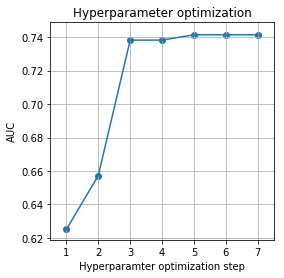

In [72]:
if optimize:
    
    aucs = [np.mean(roc_aucs_xgb1),
            gsearch0.best_score_,
            gsearch1.best_score_,
            gsearch2.best_score_,
            gsearch3.best_score_,
            gsearch4.best_score_,
            np.mean(roc_aucs_xgbopt)]
    
    fig = plt.figure(figsize=(4,4))
    plt.scatter(np.arange(1,len(aucs)+1), aucs)
    plt.plot(np.arange(1,len(aucs)+1), aucs)
    plt.xlim([0.5, len(aucs)+0.5])
    plt.ylim([0.99*aucs[0], 1.01*aucs[-1]])
    plt.xlabel('Hyperparamter optimization step')
    plt.ylabel('AUC')
    plt.title('Hyperparameter optimization')
    plt.grid()
    fig.savefig('optimization.png')

In [74]:
print (classification_report(y_true = y_df.label, y_pred = np.zeros(y_df.shape[0])))


             precision    recall  f1-score   support

          0       0.71      1.00      0.83      3588
          1       0.00      0.00      0.00      1489

avg / total       0.50      0.71      0.59      5077



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
print (classification_report(y_true = y_df.label, y_pred = xgb_opt.predict(x_df)))


             precision    recall  f1-score   support

          0       0.87      0.56      0.68      3588
          1       0.43      0.80      0.56      1489

avg / total       0.74      0.63      0.64      5077



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


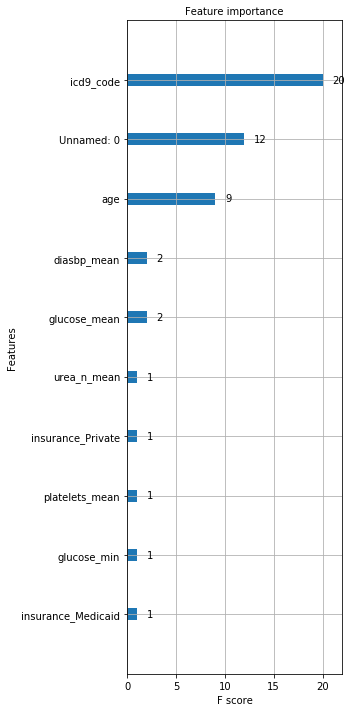

In [77]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=(figsize))
    plot_importance(booster=booster, ax=ax, **kwargs)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label,] +
ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    plt.tight_layout()
    fig.savefig('Feature_importance.png')

my_plot_importance(xgb_opt, (5,10))